In [1]:
!pip -q install tensorflow scikeras imbalanced-learn scipy


In [2]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.stats import reciprocal
import warnings
warnings.filterwarnings("ignore")


In [4]:
from sklearn.datasets import fetch_openml
import pandas as pd

try:
    df = fetch_openml("creditcard", version=1, as_frame=True).frame
except Exception:
    url = "https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv"
    df = pd.read_csv(url)


In [5]:
y = df['Class'].astype(int).values if 'Class' in df.columns else df.iloc[:, -1].astype(int).values
X = df.drop(columns=['Class']).values if 'Class' in df.columns else df.iloc[:, :-1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, cw)}


In [6]:
def build_model(n_hidden=2, units=64, dropout=0.2, lr=1e-3, input_dim=None):
    if input_dim is None:
        input_dim = X_train_s.shape[1]
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for _ in range(n_hidden):
        model.add(layers.Dense(units, activation='relu'))
        if dropout and dropout>0:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['AUC'])
    return model


Baseline
Accuracy: 0.9854
Precision: 0.0976
Recall: 0.9082
F1: 0.1762
AUC: 0.9702
Confusion Matrix:
 [[56041   823]
 [    9    89]]


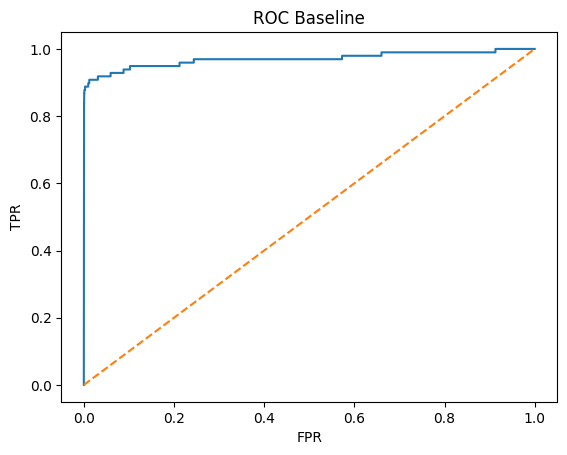

In [7]:
es = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
baseline_model = build_model(n_hidden=2, units=64, dropout=0.2, lr=1e-3, input_dim=X_train_s.shape[1])
baseline_model.fit(X_train_s, y_train, validation_split=0.2, epochs=20, batch_size=2048, callbacks=[es], verbose=0, class_weight=class_weight_dict)
p = baseline_model.predict(X_test_s, verbose=0).ravel()
y_pred = (p>=0.5).astype(int)
acc_b = accuracy_score(y_test, y_pred)
prec_b = precision_score(y_test, y_pred, zero_division=0)
rec_b = recall_score(y_test, y_pred, zero_division=0)
f1_b = f1_score(y_test, y_pred, zero_division=0)
auc_b = roc_auc_score(y_test, p)
cm_b = confusion_matrix(y_test, y_pred)
print("Baseline")
print("Accuracy:", round(acc_b,4))
print("Precision:", round(prec_b,4))
print("Recall:", round(rec_b,4))
print("F1:", round(f1_b,4))
print("AUC:", round(auc_b,4))
print("Confusion Matrix:\n", cm_b)
fpr, tpr, _ = roc_curve(y_test, p)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Baseline")
plt.show()


Tuned
Accuracy: 0.9859
Precision: 0.1016
Recall: 0.9184
F1: 0.1829
AUC: 0.974
Confusion Matrix:
 [[56068   796]
 [    8    90]]


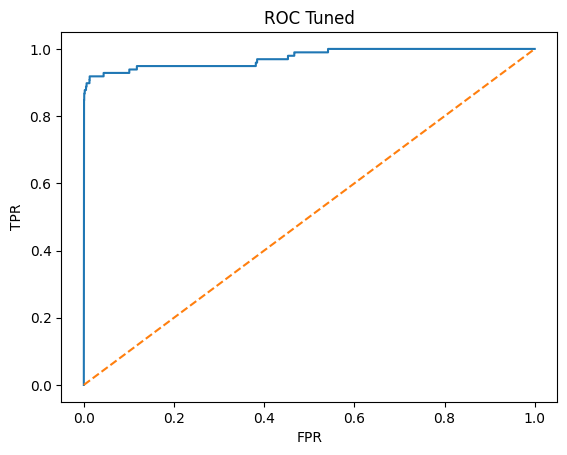

In [13]:
bp = best_params
best_gs = build_model(n_hidden=bp["n_hidden"], units=bp["units"], dropout=bp["dropout"], lr=float(bp["lr"]), input_dim=X_train_s.shape[1])
tuned = best_gs
tuned.fit(X_train_s, y_train, validation_split=0.2, epochs=bp["epochs"], batch_size=bp["batch_size"], callbacks=[es], verbose=0, class_weight=class_weight_dict)
p2 = tuned.predict(X_test_s, verbose=0).ravel()
y_pred2 = (p2>=0.5).astype(int)
acc_t = accuracy_score(y_test, y_pred2)
prec_t = precision_score(y_test, y_pred2, zero_division=0)
rec_t = recall_score(y_test, y_pred2, zero_division=0)
f1_t = f1_score(y_test, y_pred2, zero_division=0)
auc_t = roc_auc_score(y_test, p2)
cm_t = confusion_matrix(y_test, y_pred2)
print("Tuned")
print("Accuracy:", round(acc_t,4))
print("Precision:", round(prec_t,4))
print("Recall:", round(rec_t,4))
print("F1:", round(f1_t,4))
print("AUC:", round(auc_t,4))
print("Confusion Matrix:\n", cm_t)
fpr2, tpr2, _ = roc_curve(y_test, p2)
plt.figure()
plt.plot(fpr2, tpr2)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Tuned")
plt.show()


In [14]:
res = pd.DataFrame({
    "modelo": ["baseline","otimizado"],
    "accuracy": [acc_b, acc_t],
    "precision": [prec_b, prec_t],
    "recall": [rec_b, rec_t],
    "f1": [f1_b, f1_t],
    "auc": [auc_b, auc_t]
})
print(res)
res.to_csv("/content/resultados_metricas.csv", index=False)


      modelo  accuracy  precision    recall        f1       auc
0   baseline  0.985394   0.097588  0.908163  0.176238  0.970159
1  otimizado  0.985885   0.101580  0.918367  0.182927  0.974040


Tuned
Accuracy: 0.9854
Precision: 0.097
Recall: 0.898
F1: 0.1751
AUC: 0.9732
Confusion Matrix:
 [[56045   819]
 [   10    88]]


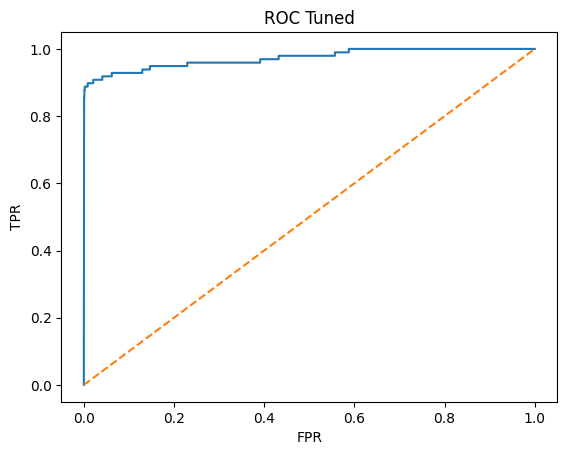

In [15]:
bp = best_params
best_gs = build_model(n_hidden=bp["n_hidden"], units=bp["units"], dropout=bp["dropout"], lr=float(bp["lr"]), input_dim=X_train_s.shape[1])
tuned = best_gs
tuned.fit(X_train_s, y_train, validation_split=0.2, epochs=bp["epochs"], batch_size=bp["batch_size"], callbacks=[es], verbose=0, class_weight=class_weight_dict)
p2 = tuned.predict(X_test_s, verbose=0).ravel()
y_pred2 = (p2>=0.5).astype(int)
acc_t = accuracy_score(y_test, y_pred2)
prec_t = precision_score(y_test, y_pred2, zero_division=0)
rec_t = recall_score(y_test, y_pred2, zero_division=0)
f1_t = f1_score(y_test, y_pred2, zero_division=0)
auc_t = roc_auc_score(y_test, p2)
cm_t = confusion_matrix(y_test, y_pred2)
print("Tuned")
print("Accuracy:", round(acc_t,4))
print("Precision:", round(prec_t,4))
print("Recall:", round(rec_t,4))
print("F1:", round(f1_t,4))
print("AUC:", round(auc_t,4))
print("Confusion Matrix:\n", cm_t)
fpr2, tpr2, _ = roc_curve(y_test, p2)
plt.figure()
plt.plot(fpr2, tpr2)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Tuned")
plt.show()


In [17]:
res = pd.DataFrame({
    "modelo": ["baseline","otimizado"],
    "accuracy": [acc_b, acc_t],
    "precision": [prec_b, prec_t],
    "recall": [rec_b, rec_t],
    "f1": [f1_b, f1_t],
    "auc": [auc_b, auc_t]
})
print(res)
res.to_csv("/content/resultados_metricas.csv", index=False)


      modelo  accuracy  precision    recall        f1       auc
0   baseline  0.985394   0.097588  0.908163  0.176238  0.970159
1  otimizado  0.985446   0.097023  0.897959  0.175124  0.973208
